<a href="https://colab.research.google.com/github/DmitryPavlyuk/python-da/blob/main/data/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Time Series Forecasting

Topics:
- **Introduction to TS**
- **Naive approaches**
- **Statistical
 - **Smoothing techniques (MA, ES**
 - **ARIMA**

## Introduction

1. What is Time Series?
1. Example dataset
1. Components of Time Series
1. Forecasting Process: split data, metrics

**What is time series?**

Time series (TS) is a sequence of data that has some order in a set interval like time. It may not have be temporal, as long the data some ordering such as DNA sequences.

**Time Series Analysis vs. Forecasting**

 - Analysis is interested in anlyzing and understanding of the time series to describe the pattern or its seasonality.
 - Forecasting is to predict the future value.

**Tasks involved in TS**
- EDA (Exploritory Data analysis): seasonality, nature of temporial process
- Prediction/Forecasting future values
- Classification type of TS
- Anomaly Detection

**Types of TS: Univariate vs. multivariate**
- univariate: time series with a single observation per time increments.
- multivariate: series has more than one time-dependent variables that capture the dynamic of multiple time series.



### Dataset
- Monthly newborns in Latvia (2012-2022)

In [49]:
!pip install statsmodels
!pip install pmdarima

In [50]:
#Download data locally
#!curl -O https://raw.githubusercontent.com/DmitryPavlyuk/python-da/main/data/newborns.csv
#!curl -O https://raw.githubusercontent.com/DmitryPavlyuk/python-da/main/data/milk.csv


In [51]:

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('newborns.csv')
df.head(5)

,Month,NewbornsTotal,Days,NewbornsPerDay
0,2012M01,1588,31,51.2
1,2012M02,1451,29,50.0
2,2012M03,1644,31,53.0
3,2012M04,1640,30,54.7
4,2012M05,1718,31,55.4


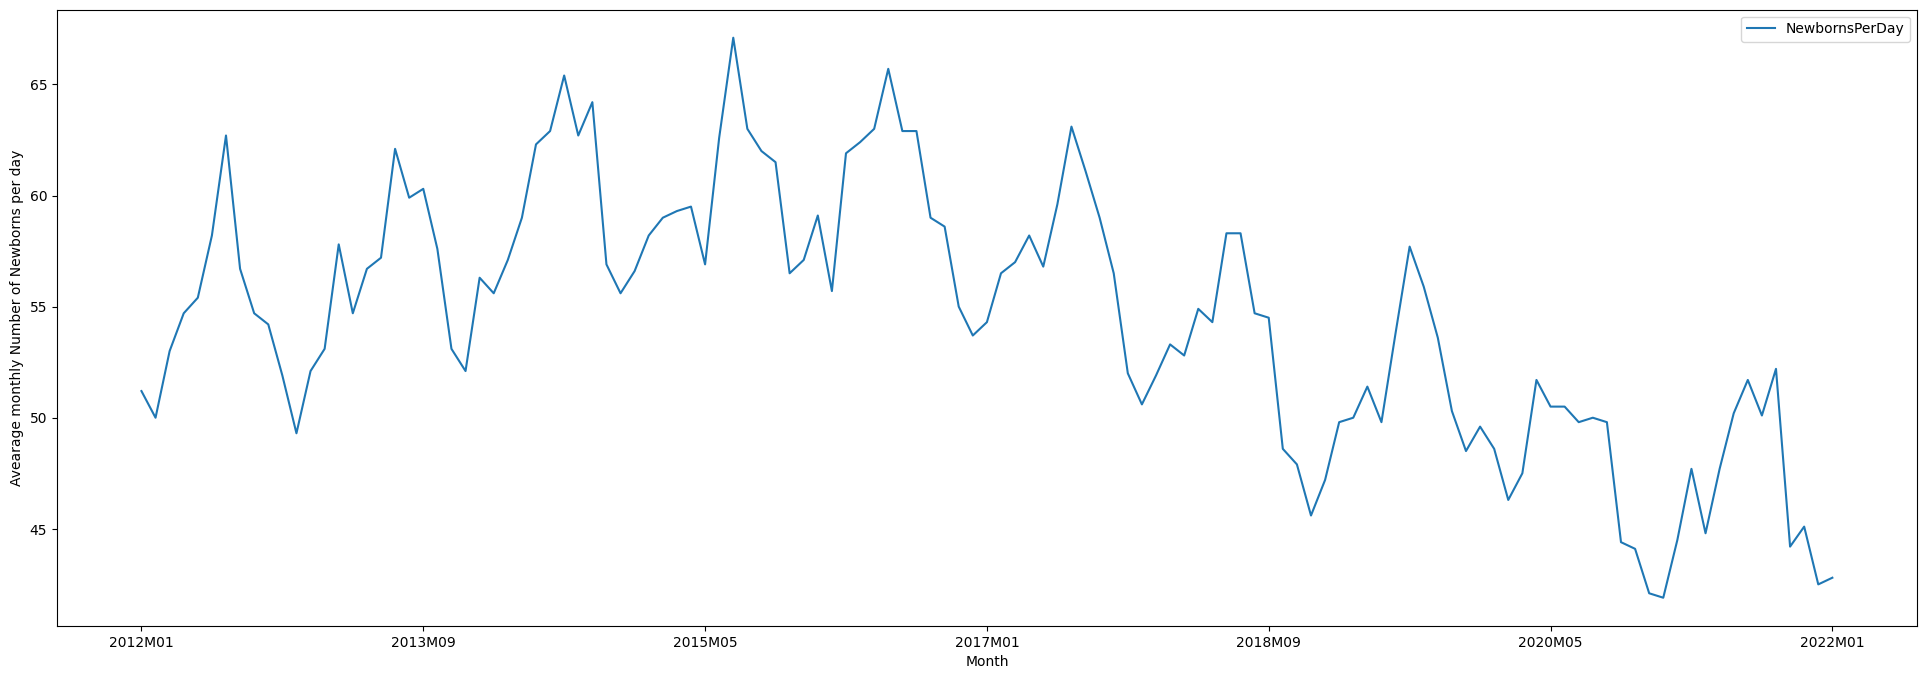

In [52]:
df = df[["Month", "NewbornsPerDay"]]
ax = df.set_index('Month').plot(figsize=(24, 8))
ax.set_ylabel('Avearage monthly Number of Newborns per day')
ax.set_xlabel('Month')
plt.show()

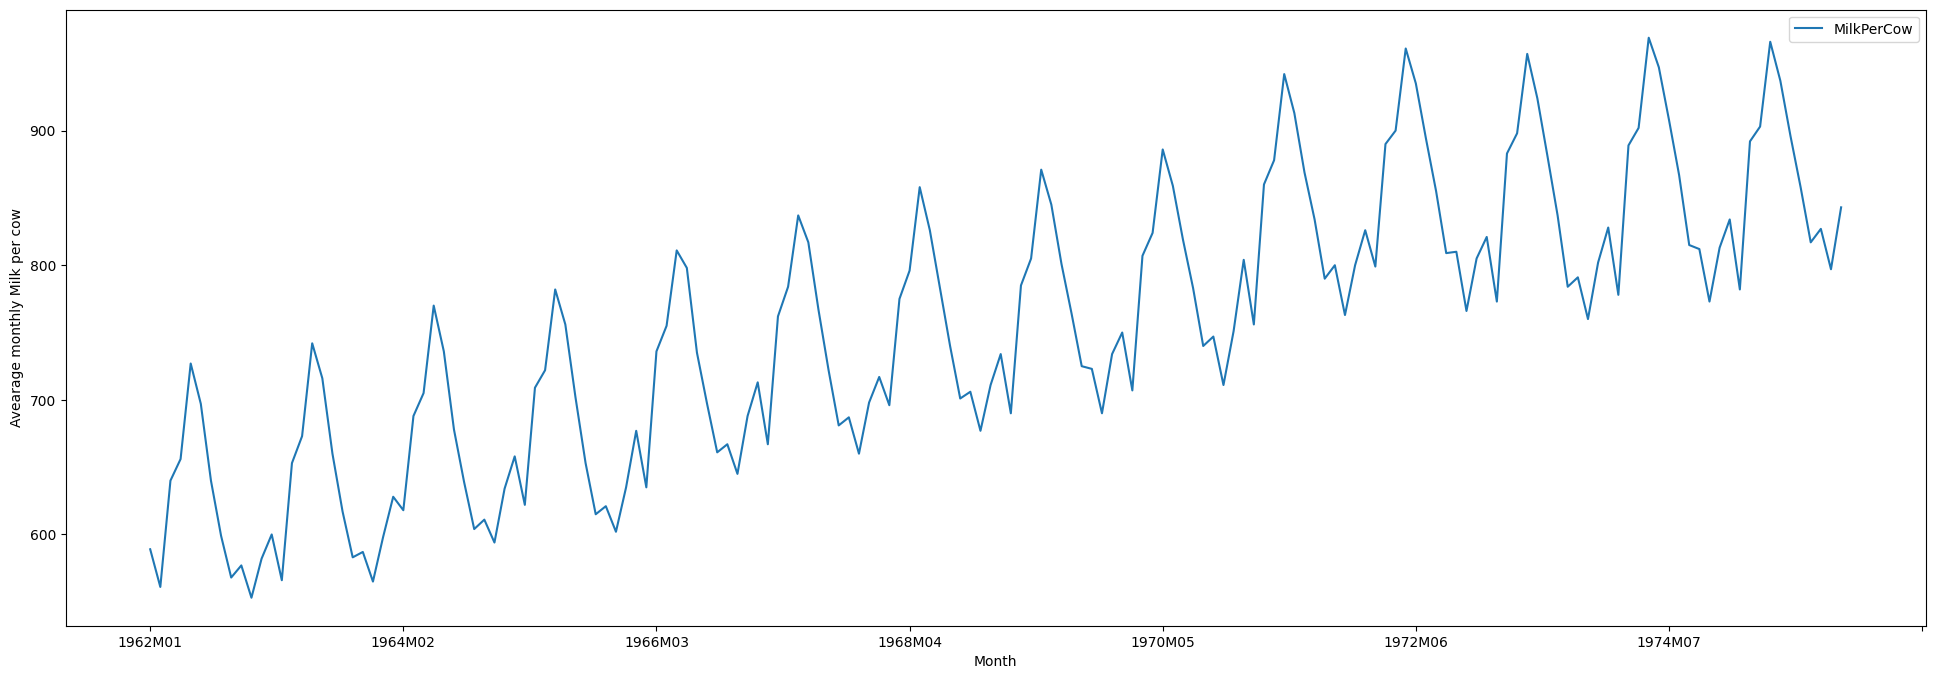

In [53]:

df2 = pd.read_csv('milk.csv')
df2 = df2[["Month", "MilkPerCow"]]
ax = df2.set_index('Month').plot(figsize=(24, 8))
ax.set_ylabel('Avearage monthly Milk per cow')
ax.set_xlabel('Month')
plt.show()

### Components of Time Series
**Classical Decomposition**
A basic model for representing a time series:

$y_t = \mu_t + \gamma_t + \varepsilon_t$

where
 - $y_t$ = observation,
 - $\mu_t$ = slowly changing component (trend),
 - $\gamma_t$ = periodic component (seasonality),
 - $\varepsilon_t$ = irregular component (noise).

Time series consists of:
 0. Level: local mean of the series
 1. Trend: estimate of the change between successive time points
 2. Seasonality: the deviation from the local mean due to seasonality
 3. Noise: residual components or random variation

$y_t = level + trend + seasonality + noise$


In [54]:
# format data for time series
data = df
data['year'] = data['Month'].str.extract(r'(\d{4})').astype(int)
data['month'] = data['Month'].str.extract(r'M(\d+)').astype(int)
data['day'] = 1
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data = data.set_index('date').drop(["Month","year","month", "day"], axis=1)
data.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS'))
data = data["NewbornsPerDay"]
data

,NewbornsPerDay
date,
2012-01-01,51.2
2012-02-01,50.0
2012-03-01,53.0
2012-04-01,54.7
2012-05-01,55.4
...,...
2021-09-01,52.2
2021-10-01,44.2
2021-11-01,45.1


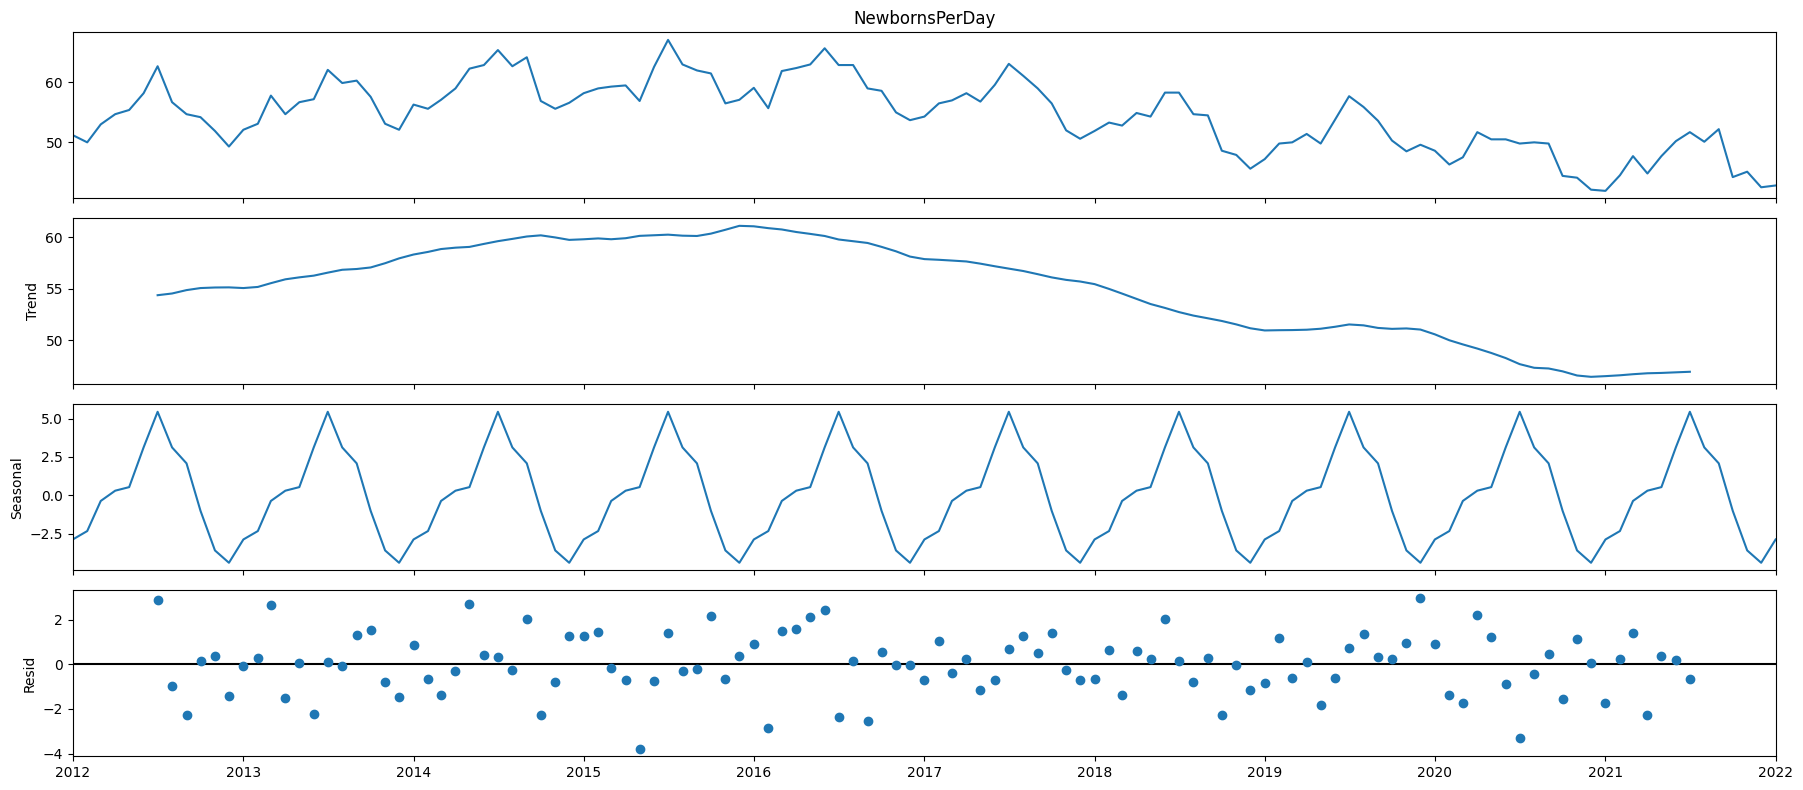

In [55]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive')
fig = decomposition.plot()
plt.show()

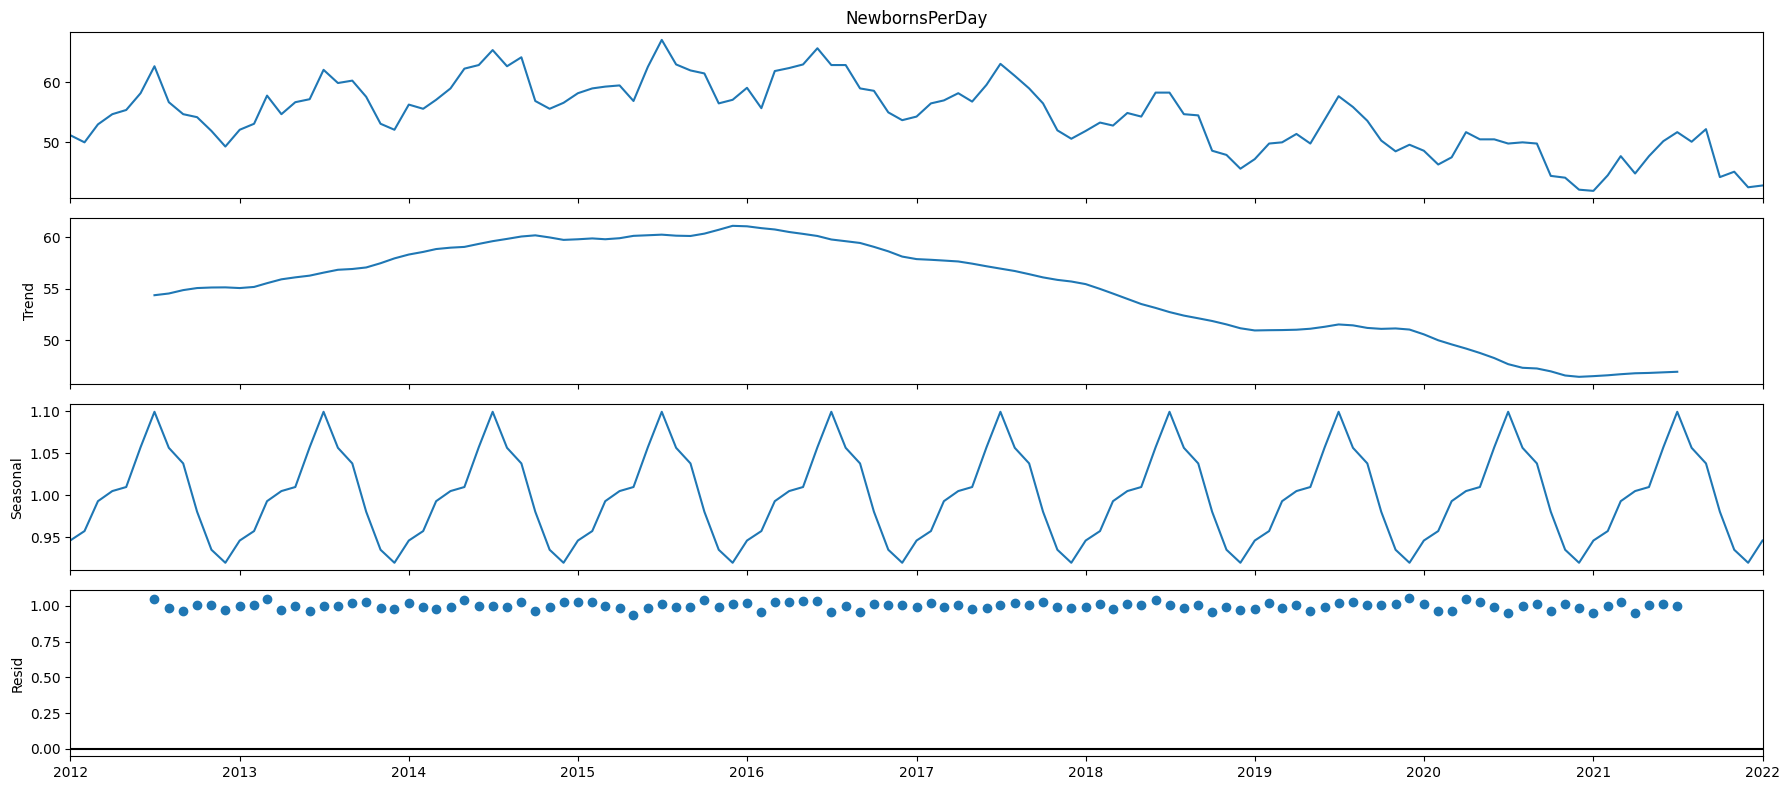

In [56]:
fig = sm.tsa.seasonal_decompose(data, model='multiplicative').plot()
plt.show()

### Predictions and Metrics


Before we can measure the performance we need to split our data into training and test set before running the experiment.

**Types of prediction**

We want to forecast into the future. There are two approaches of prediction:
 1. One-step ahead prediction
 2. Multi-horizons forecast

**Train and Test Split**

So in our dataset, we want to train on earlier part of the dataset and left out the later part of the dataset to evaluate how well the model does. So we don't want to randomly split the dataset.
- Training set: the first 80% of the data
- Test set: 20% of the latest part of the data, or predict last year or last month.

**Metrics**

To measue how well the algorithm perform, we'll choose one of the metrics below:
- MSE: Mean Squared Error = $\frac{\sum (\hat y - y) ^ 2}{n}$ <br/> `np.square(y_hat - y).mean()`
- RMSE: Root Mean Squared Error = `np.sqrt(MSE)`
- MAE: mean absolute error = $\frac{\sum |\hat y - y|}{n}$ <br/> `abs(y_hat - y).mean()`
- MAD: mean absolute deviation = $\frac{\sum |\hat y_i - \bar y|}{n}$ <br/> `abs(y_hat - y.mean()).mean()`
- MAPE: mean absolute percentage error = $\frac{1}{n} \sum \frac{| y - \hat y |}{y} * 100 $ <br/>`(abs(y - y_hat) / y).mean() * 100`
- sMAPE: Symmetric mean absolute percentage error (scales the error by the average between the forecast and actual) = $\frac{\sum{| y - \hat y |}}{\sum{(y+\hat y)}} * 100$  <br/>
`abs(y - y_hat).sum/(y + y_hat).sum() * 100`
- MASE: Mean Absolute Scaled Error --scales by the average error of the naive null model
= $\frac{1}{n} \sum \frac{| \hat y - y |}{\frac{1}{T+n-m}\sum_j^{T+n} |y_{j} - y_{j-m}|}$

where
> - $y$ : the ground truth observation value
> - $\hat y$ : predicted value
> - $m$ : periodicity,
> - $n$ : forecast horizon

## Naive Approaches
We need a baseline approach so we can compare our fancy algorithms and see how well it does compare to the naive algorithms.




Here are different naive approaches:

- Null model: predict the next value as the previous one (persistence model)
- Seasonal Naive: give a season, the next value is same as previous season value
- Mean: take an average of all previous values as the forecast value
- Random Walk: randomly add noise to prediction of previous value

In [57]:
n = len(data)
n_test = 24
n_train = n - n_test

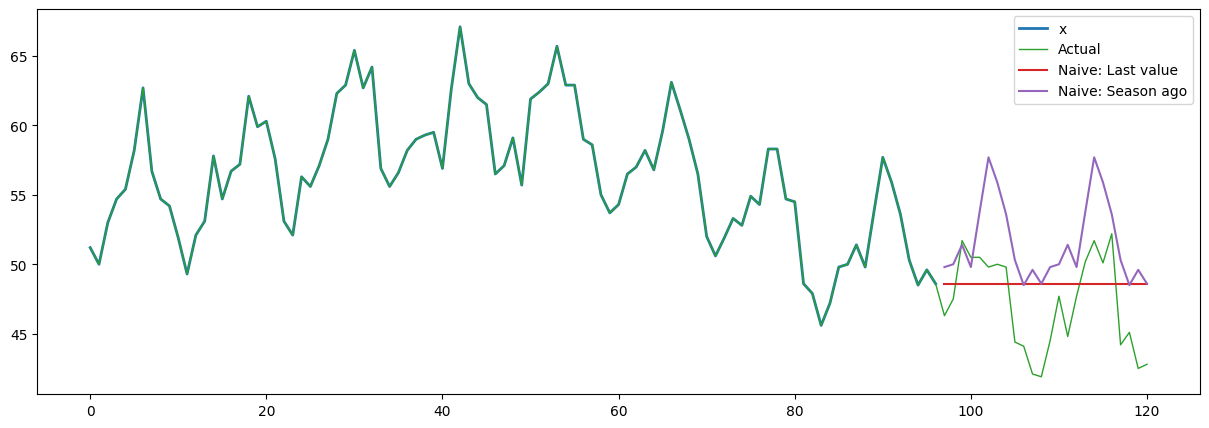

In [58]:
import numpy as np
import pylab as pl

x = data[0:n_train]
extrapolation = np.zeros(n_test)
extrapolation += x.iloc[n_train-1]
seasonal = np.append(x[(n_train-12):n_train],x[(n_train-12):n_train])

plt.subplots(figsize=(15,5))
pl.plot(np.arange(0, n_train), x, 'C0', label='x', linewidth=2)
pl.plot(np.arange(0, n), data, 'C2', label='Actual', linewidth=1)
pl.plot(np.arange(n_train, n_train+extrapolation.size), extrapolation, 'C3', label='Naive: Last value')
pl.plot(np.arange(n_train, n_train+seasonal.size), seasonal, 'C4', label='Naive: Season ago')
pl.legend()
pl.show()

In [59]:
# test period

diff = np.abs(data[n_train:n] - extrapolation)
#print("type diff:", type(diff)) #type diff: <class 'pandas.core.series.Series'>
naive_mae = diff.mean()
print("Naive Last Val MAE:", naive_mae)

diff = np.abs(data[n_train:n] - seasonal)
seasonal_mae = diff.mean()
print("Seasonal Naive MAE:", seasonal_mae)

Naive Last Val MAE: 3.1375000000000006
Seasonal Naive MAE: 4.495833333333333


## Smoothing
Smoothing with moving average to exponential smoothing is a way to filter out some of the noises in the data.

### Moving Average

**Simple Moving Average**

$y_t = (x_t + x_{t-1} + x_{t-2} + ... + x_{t-n-1})/n$

where $n$ is number of data point to smooth

```
pandas.DataFrame.mean()
pandas.DataFrame.rolling(n, center=False).mean()
```
Center and Trailing Moving Average

**Weighted Moving Average**

$y_t =  \cfrac{x_t * n + x_{t-1} * (n-1) + x_{t-2} * (n-2) + ... x_{t-n-1}} {\frac{n (n+1)}{2}}$


```
pandas.DataFrame.rolling(n).mean()
pandas.DataFrame.rolling(n, win_types='exponential').mean()
```

**Exponential Weighted Moving Average**

Simple Exponential Smoothing (Holt Linear)

$y_0=x_0$

$y_t = \alpha x_{t} + (1-\alpha)y_{t-1}$

- $\alpha$ : smoothing factor and $ 0<\alpha<1 $ ; lower value means more smoothing
- $y_t$ approximate over $\cfrac{1}{\alpha}$ data points

ie. $\alpha$ = 0.5 ≈ 2 data points, 0.1 ≈ 10 data points, 0.02 ≈ 50 data points

```
pandas.DataFrame.ewm(alpha=0.12).mean()
```
$y_t=(1−α)y_{t−1}+αx_t$

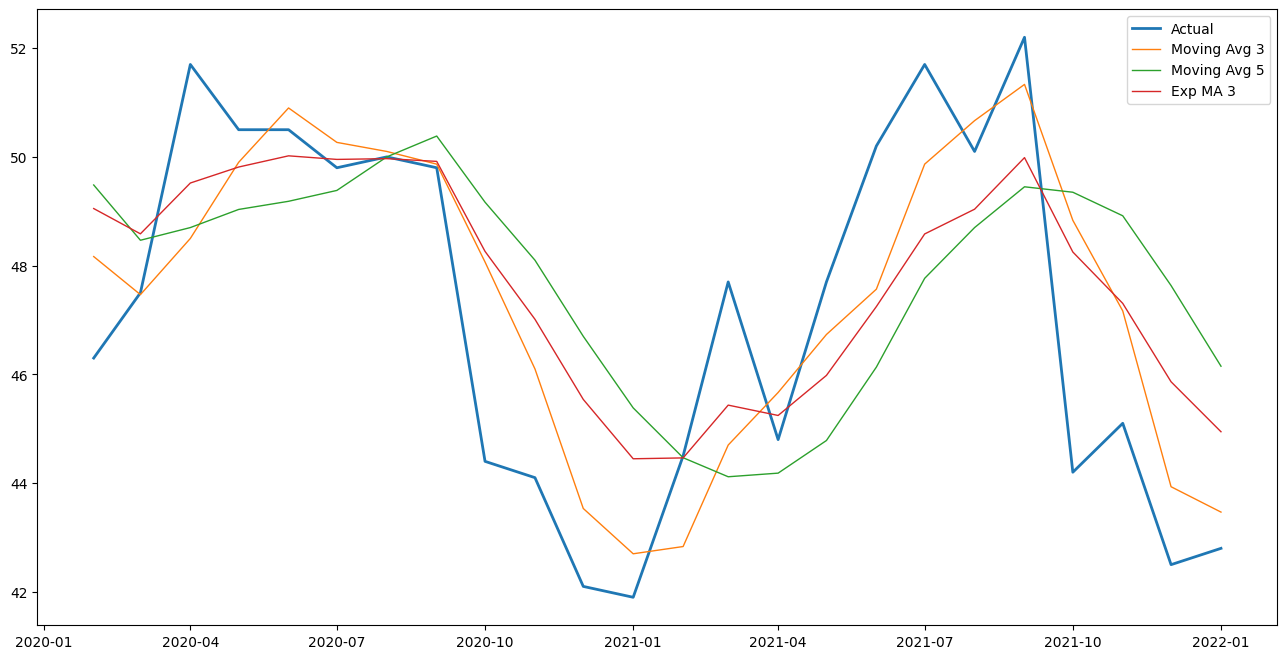

In [60]:
import pandas as pd
import pylab as pl

ma1 = data.rolling(3).mean()
ma2 = data.rolling(6).mean()

expma = data.ewm(alpha=0.3).mean()

pl.subplots(figsize=(16,8))
pl.plot(data.index[n_train:], data[n_train:], 'C0', label='Actual', linewidth=2)
pl.plot(data.index[n_train:], ma1[n_train:], 'C1', label='Moving Avg 3', linewidth=1)
pl.plot(data.index[n_train:], ma2[n_train:], 'C2', label='Moving Avg 5', linewidth=1)
pl.plot(data.index[n_train:], expma[n_train:], 'C3', label='Exp MA 3', linewidth=1)

pl.legend()
pl.show()

### Exponential Smoothing

**Linear Exponential Smoothing (Holt ES)**
- shown earlier as Exponential Weighted Moving Average
- Simple Exponential Smoothing

**Double Exponential Smoothing**
- Holt-Winters double exponential smoothing
- which handle trend at time t, as $b_t$

>$y_0 = x_0$

>$b_0 = x_1 - x_0$

$y_t = \alpha x_t + (1 - \alpha) (y_{t-1} + b_{t-1})$

$b_t = \beta(y_t - y_{t-1}) + (1-\beta)b_{t-1}$

where
- $0\leq \alpha \leq 1$ : the data smoothing factor
- $0\leq \beta \leq 1$  : the trend smoothing factor

**Prediction:** $ y_{t+m} = y_t + b_tm $

&nbsp;

**Triple Exponential Smoothing (Holts-Winters ES)**
- Triple exponential smoothing (Holt Winters)
- Handle trend and seasonality where L is a cycle length

> $y_0 = x_0$

$y_t = \alpha \cfrac {x_t}{c_t -L} + (1 - \alpha) (y_{t-1} + b_{t-1})$

$b_t = \beta(y_t - y_{t-1}) + (1-\beta)y_{t-1}$

$c_t = \gamma \cfrac{x_t}{y_t} + (1-\gamma)c_{t-L}$

where
- $0\leq \alpha \leq 1$ : the data smoothing factor,
- $0\leq \beta \leq 1$  : the trend smoothing factor
- $0\leq \gamma \leq 1$ : the seasonal change smoothing factor
- $L$ : cycle of seasonal change

**Prediction:** $y_{t+m} = (y_t + mb_t)c_{t-L+(m-1) \mod L}$

&nbsp;

In [61]:
test = data[n_train:].asfreq("MS")
train = data[:n_train].asfreq("MS")

In [62]:
test

,NewbornsPerDay
date,
2020-02-01,46.3
2020-03-01,47.5
2020-04-01,51.7
2020-05-01,50.5
2020-06-01,50.5
2020-07-01,49.8
2020-08-01,50.0
2020-09-01,49.8
2020-10-01,44.4


MAE moving_avg_forecast: 6.0583333333333345
MAE SES: 3.2118021965552175


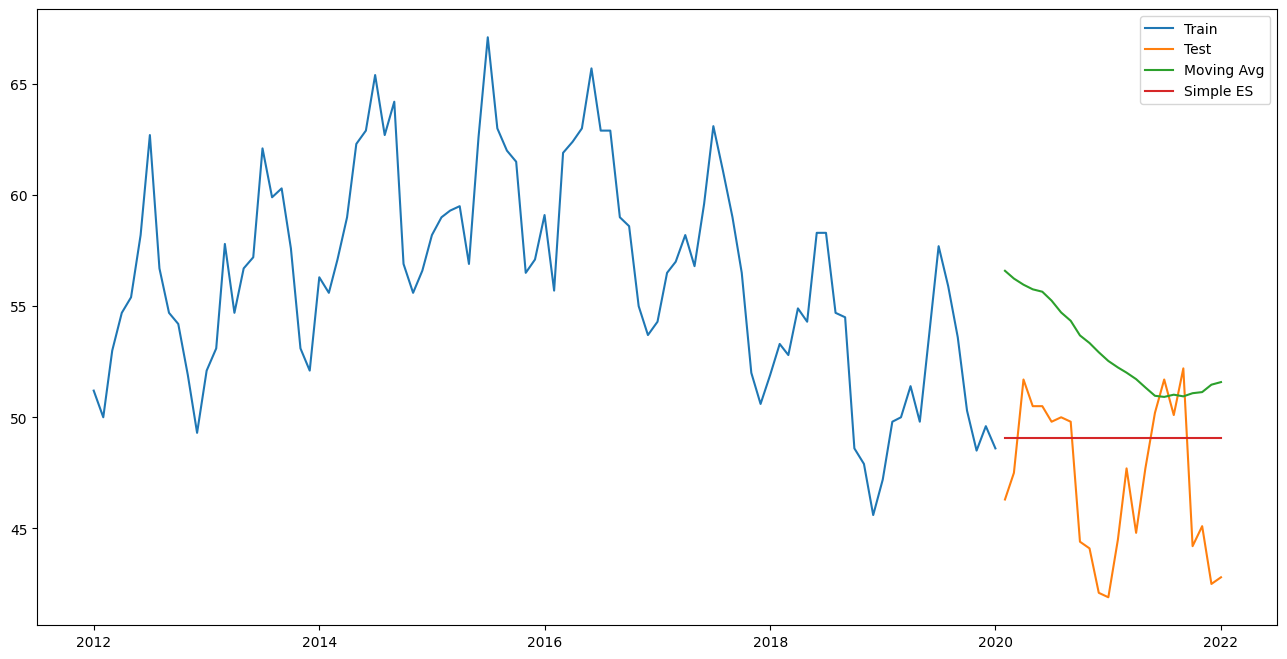

In [63]:
# Predict using Moving Average vs. Simple Exponential Smoothing (Holt ES)
import numpy as np

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = train.rolling(12).mean().iloc[-n_test:]
y_hat_avg.index = test.index
diff = abs(y_hat_avg  - test)
ma_mae = diff.mean()
print("MAE moving_avg_forecast:", ma_mae)

fit2 = SimpleExpSmoothing(np.asarray(train)).fit(smoothing_level=0.6,optimized=False)
y_SES = pd.Series(fit2.forecast(len(test)))
y_SES.index = test.index
diff = abs(y_SES  - test)
ses_mae = diff.mean()
print("MAE SES:", ses_mae)

plt.figure(figsize=(16,8))
plt.plot(train.index, train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_avg, label='Moving Avg')
plt.plot(y_SES, label='Simple ES')
plt.legend(loc='best')
plt.show()

                              Holt Model Results                              
Dep. Variable:         NewbornsPerDay   No. Observations:                   97
Model:                           Holt   SSE                           1415.971
Optimized:                      False   AIC                            268.043
Trend:                       Additive   BIC                            278.342
Seasonal:                        None   AICC                           268.977
Seasonal Periods:                None   Date:                 Thu, 17 Apr 2025
Box-Cox:                        False   Time:                         15:08:01
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.3000000                alpha                False
smoothing_trend            0.1000000                

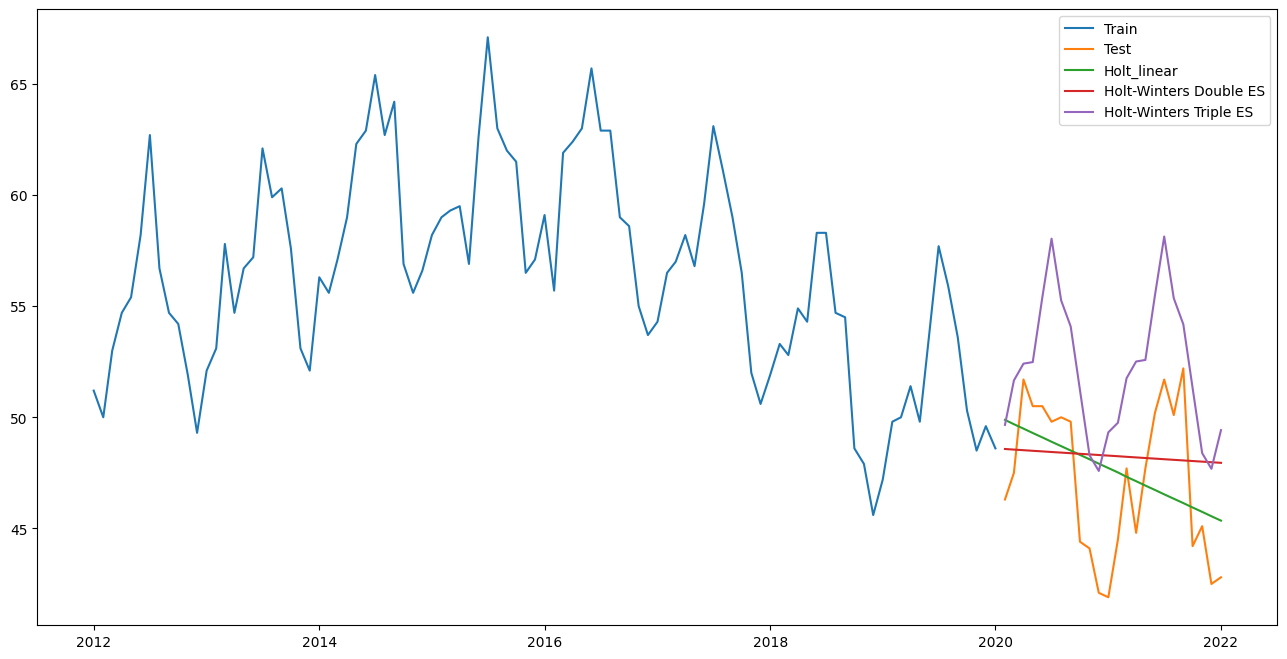

In [64]:
from statsmodels.tsa.api import Holt, ExponentialSmoothing

fit1 = Holt(train).fit(smoothing_level = 0.3,smoothing_trend = 0.1,optimized=True)
Holt_linear = pd.Series(fit1.forecast(len(test)))
Holt_linear.index = test.index
print(fit1.summary())
diff = abs(Holt_linear  - test)
holt_mae = diff.mean()
print("MAE Holt_linear:", holt_mae)


model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal=None)
fitted = model.fit()
print(fitted.summary())

forecast_trend = fitted.forecast(steps=n_test)
diff = abs(forecast_trend - test)
es_mae = diff.mean()
print("MAE Double ES:", es_mae)

from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add')
fitted = model.fit()
print(fitted.summary())

forecast = fitted.forecast(steps=n_test)

diff = abs(forecast - test)
hw_mae = diff.mean()
print("MAE Holt-Winter mult:", hw_mae)
plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(Holt_linear, label='Holt_linear')
plt.plot(forecast_trend, label='Holt-Winters Double ES')
plt.plot(forecast, label='Holt-Winters Triple ES')
plt.legend(loc='best')
plt.show()

### ARIMA Family
Classical Box-Jenkins methodology with ARIMA including AR, MA, ARMA, SARIMA, and SARIMAX.

- There are other variances such as VAR (Vector Auto Regression), VARMA, and VARMAX. See link: https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
- Other approach like: ARCH and GARCH which handle change in variance. (https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/)


### ARMA

**AR** : Auto Regression -- uses the dependent relationship between an observation and some number of lagged observations.

Linear Regression using lag values as features. The lag $n$ value is the previous $n$ value.
>- lag1 = $x_{n-1}$
>- lag2 = $x_{n-2}$

Paramer lags can be a number N or a list. For example:
>- ``lags=3 `` is using lag1, lag2, lag3.
>- ``lags=[1,3]`` is using lag1, lag3.

**MA** : Moving Average -- uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The ARMA(1, 1) model is:

> - $y_t = \phi_1 y_{t-1} + \theta_1 \varepsilon_{t-1} + \varepsilon_t$
 - $\phi_1 y_{t-1}$: AR term
 - $\theta_1 \varepsilon_{t-1}$: MA term
> - Prediction: $\hat y_t = \phi_1 y_{t-1} + \theta_1 \varepsilon_{t-1}$

**Notations:**
ARMA(p,q)  where
- p is the AR order and
- q is the MA order

### ARIMA

ARIMA is adding "I" to ARMA where:
- **I** : Integrated -- uses the differencing of raw observations in order to make the time series stationary.

Differencing gives:
$z_t=y_{t+1} - y_t$

ARIMA: $z_t=\phi z_{t-1}+\theta \varepsilon_{t-1} + \varepsilon_t$
>reverse transform:
$y_t=\sum_{i=1}^{t-l} z_{t-i} + y_l$
where l is last time index

**Notations:**

- The ARIMA notation is ``ARIMA(p,d,q)``
where d is the order of integration, or number of differences.
- ``ARMA(p,q)`` is equivalent to ``ARIMA(p,0,q)``

> - p: The number of lag observations included in the model, also called the **lag order**.
- d: The number of times that the raw observations are differenced, also called the **degree of differencing**.
- q: The size of the moving average window, also called the **order of moving average**.

Ref:
- https://www.quora.com/How-does-the-ARMA-model-differ-from-the-ARIMA-model-In-what-situation-is-the-ARMA-model-appropriate

### Test of Stationary
ARIMA works on stationary data. So we need the intergration(I) process to ensure the data is stationary.

Stationarity if all of the following conditions are true:
- mean ($\mu$) is constant
- standard diviation ($\sigma$) is constant
- no seasonality

Check for stationarity:
- visually look at the chart
- do global vs local tests
- use Augmented Dickey-Fuller (ACF) test

Interpret ACF Result:
Using the p-value from the test:
 - p-value <= 0. 05 : stationary
 - p-value > 0. 05 : non-stationary

Make Stationary in integration process:
- use differencing: $z_t = y_t - y_{t-1}$
- may need second, third, or more differencing
- where $d$ value in ARIMA(p,d,q) is set

ACF vs PACF Test:
- ACF: Augmented Dickey-Fuller
 - MA - direct and indirect lags dependencies
- PACF: Partial Augmented Dickey-Fuller
 - AR - direct lags dependencies

Ref:
- https://machinelearningmastery.com/time-series-data-stationary-python/
- https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8


ADF Statistic: 0.428619
p-value: 0.982534
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581


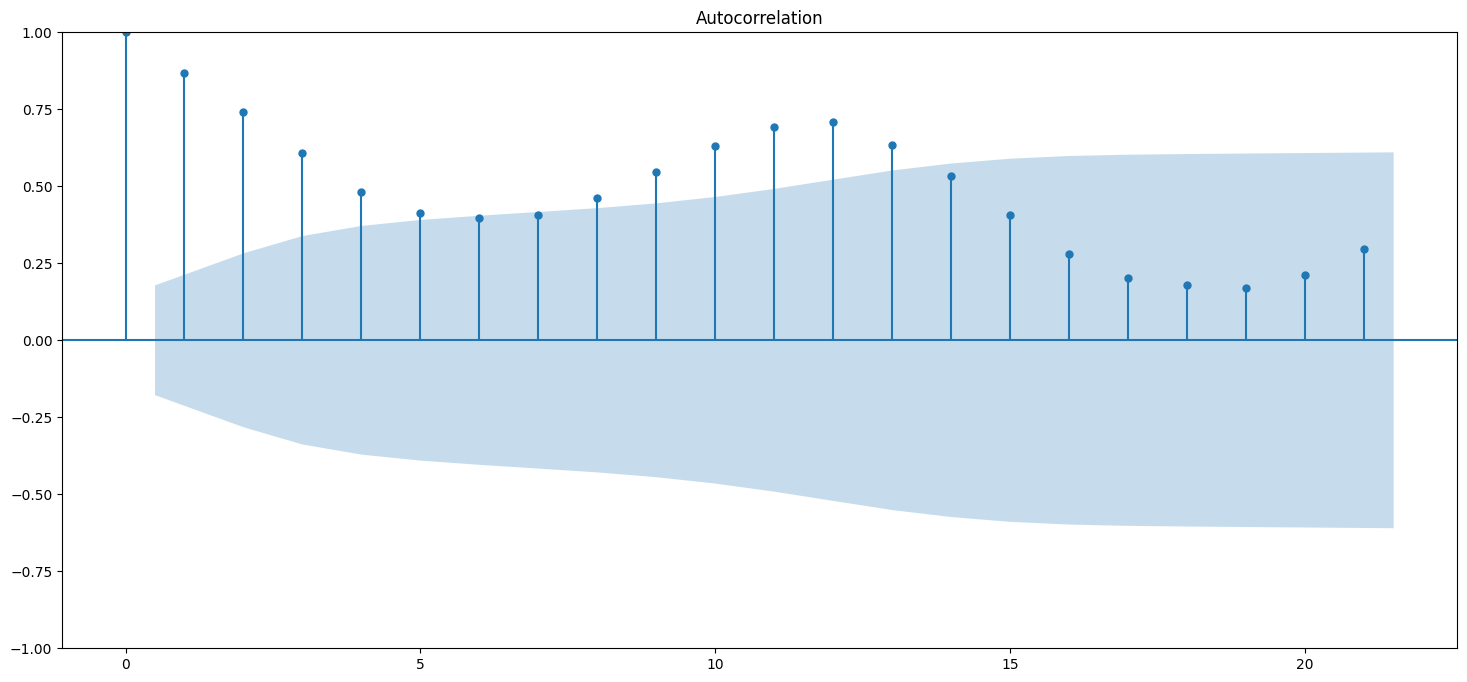

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
#data = read_csv('AirPassengers.csv', header=1, index_col=0) #load data first, don't need this

result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

plot_acf(data)
plt.show()

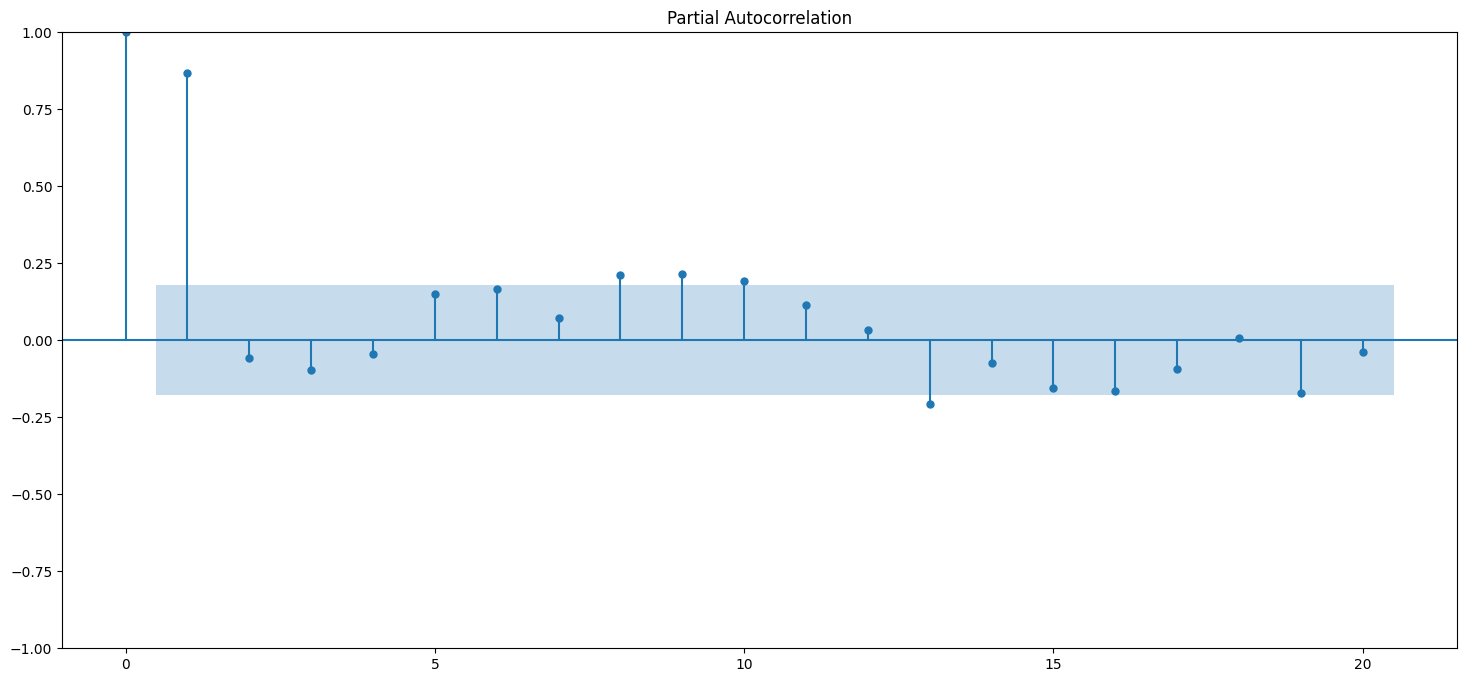

In [66]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data, lags=20, method='ywm')
plt.show()

### ARIMA Prediction

In [67]:
# @title
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")


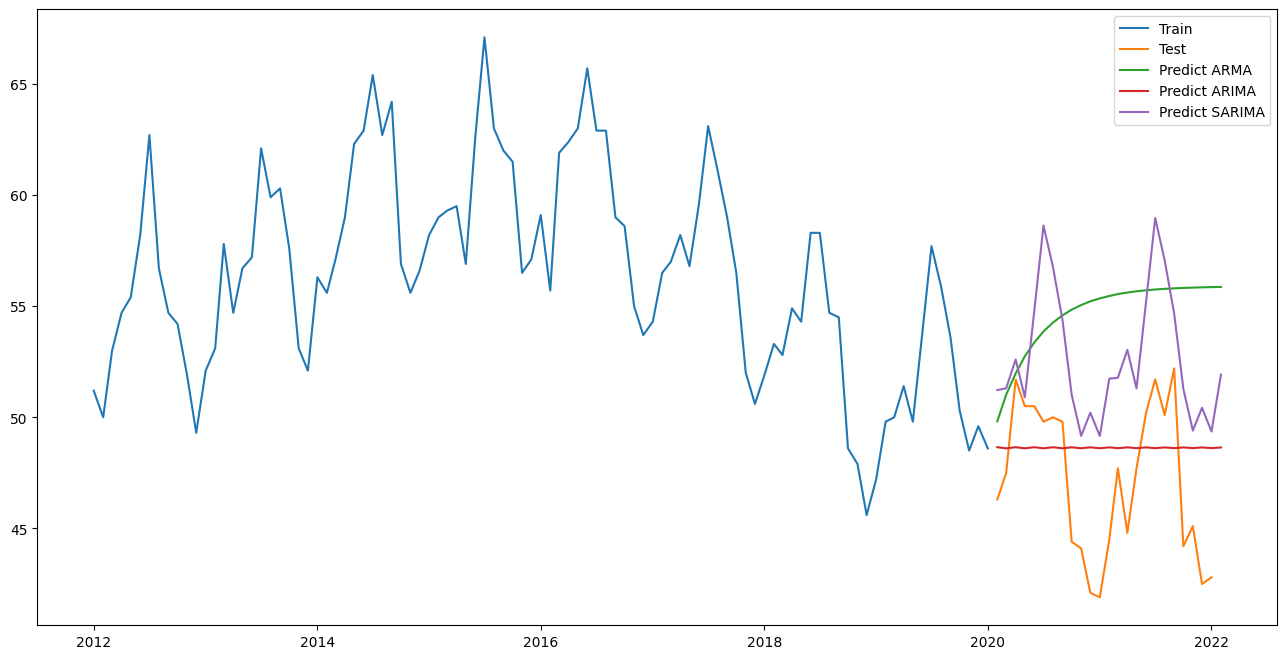

MAE ARMA: 7.445285875895894
MAE ARIMA: 3.1421349335194857
MAE SARIMA: 5.5106847079575205


In [68]:
# ARMA model

from statsmodels.tsa.arima.model import ARIMA

model_arma = ARIMA(train, order=(1, 0, 1))
model_arma_fit = model_arma.fit()
model_arima = ARIMA(train, order=(1, 1, 1))
model_arima_fit = model_arima.fit()
model_sarima = ARIMA(train, order=(1, 0, 1), seasonal_order =(0, 1, 0, 12))
model_sarima_fit = model_sarima.fit()

yhat_arma = model_arma_fit.predict(len(train), len(train)+len(test))
yhat_arima = model_arima_fit.predict(len(train), len(train)+len(test))
yhat_sarima = model_sarima_fit.predict(len(train), len(train)+len(test))

plt.figure(figsize=(16,8))
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(yhat_arma, label='Predict ARMA')
plt.plot(yhat_arima, label='Predict ARIMA')
plt.plot(yhat_sarima, label='Predict SARIMA')
plt.legend(loc='best')
plt.show()

MAE = abs(yhat_arma - test).mean()
print("MAE ARMA:", MAE)
MAE = abs(yhat_arima - test).mean()
print("MAE ARIMA:", MAE)
MAE = abs(yhat_sarima - test).mean()
print("MAE SARIMA:", MAE)

#### ARIMA Parameters Search

In [69]:
!pip install pmdarima

In [70]:
import warnings
import itertools
import statsmodels.api as sm
import numpy as np

warnings.filterwarnings("ignore")

# Set parameter ranges
p = q = range(0, 4)
d = 1
D = 1
P = Q = range(0, 3)
seasonal_period = 12

# Generate all combinations of p, d, q
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = list(itertools.product(P, [D], Q, [seasonal_period]))

# Placeholder for the best model
best_aic = np.inf
best_params = None
best_seasonal_params = None
best_model = None

print("Searching for best SARIMA model...")

# Loop through all combinations
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(data,
                                              order=param,
                                              seasonal_order=seasonal_param,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            results = model.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = seasonal_param
                best_model = results

            print(f"Checked SARIMA{param}x{seasonal_param} - AIC: {results.aic:.2f}")

        except Exception as e:
            continue

print("\nBest model found:")
print(f"SARIMA{best_params}x{best_seasonal_params} - AIC: {best_aic:.2f}\n")
print(best_model.summary())


Searching for best SARIMA model...
Checked SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC: 533.15
Checked SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC: 434.49
Checked SARIMA(0, 1, 0)x(0, 1, 2, 12) - AIC: 383.72
Checked SARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC: 450.44
Checked SARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC: 438.18
Checked SARIMA(0, 1, 0)x(1, 1, 2, 12) - AIC: 381.12
Checked SARIMA(0, 1, 0)x(2, 1, 0, 12) - AIC: 387.64
Checked SARIMA(0, 1, 0)x(2, 1, 1, 12) - AIC: 388.73
Checked SARIMA(0, 1, 0)x(2, 1, 2, 12) - AIC: 382.73
Checked SARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC: 508.71
Checked SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC: 401.51
Checked SARIMA(0, 1, 1)x(0, 1, 2, 12) - AIC: 351.49
Checked SARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC: 413.55
Checked SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC: 399.30
Checked SARIMA(0, 1, 1)x(1, 1, 2, 12) - AIC: 344.52
Checked SARIMA(0, 1, 1)x(2, 1, 0, 12) - AIC: 360.48
Checked SARIMA(0, 1, 1)x(2, 1, 1, 12) - AIC: 361.61
Checked SARIMA(0, 1, 1)x(2, 1, 2, 12) - AIC: 345.92
Checked SARIMA(0, 1, 2)x(0, 1

#### Model

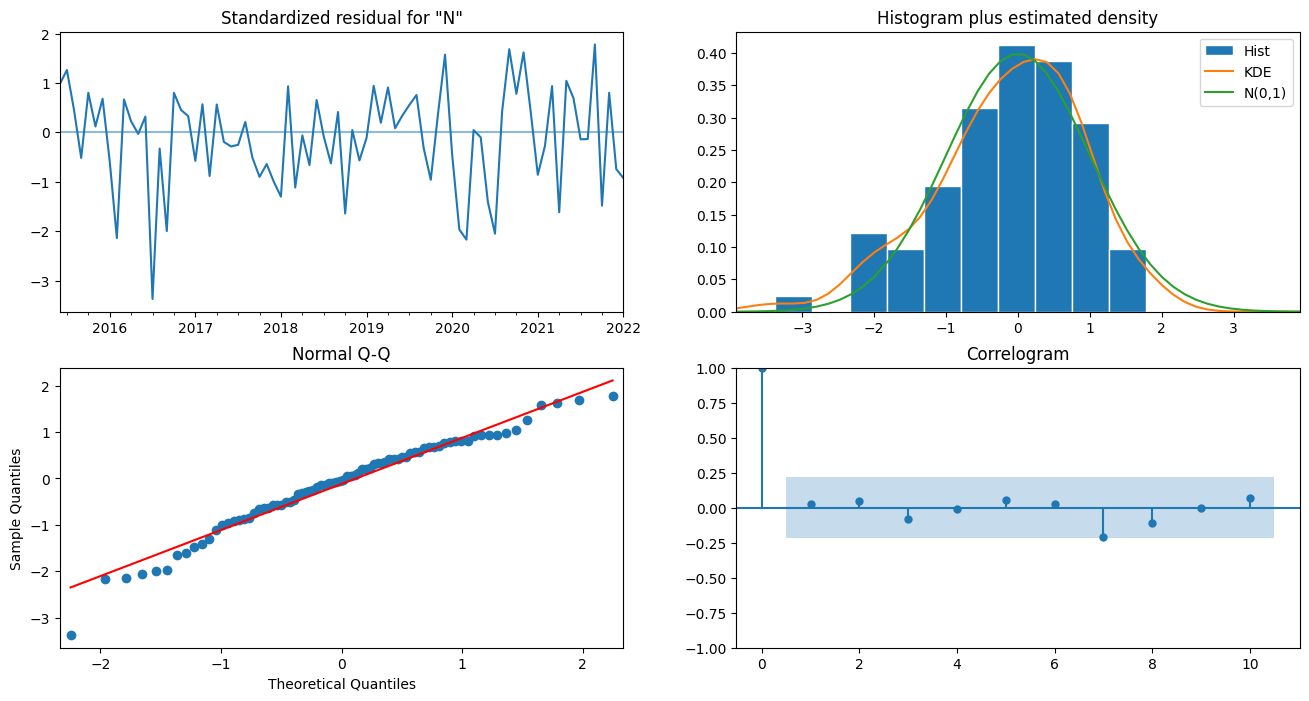

In [71]:
best_model.plot_diagnostics(figsize=(16, 8))
plt.show()

In [72]:
pred = best_model.get_prediction(start=min(test.index),end=max(test.index), dynamic=False)

pred_test = pred.conf_int()
res = pred.predicted_mean
pred_test["result"] = pred.predicted_mean
pred_test["y"] = test
print("pred_test:\n", pred_test)

pred_test:
             lower NewbornsPerDay  upper NewbornsPerDay     result     y
2020-02-01             46.311298             52.867957  49.589628  46.3
2020-03-01             47.851958             54.371755  51.111857  47.5
2020-04-01             48.372217             54.876520  51.624369  51.7
2020-05-01             47.413755             53.918054  50.665904  50.5
2020-06-01             49.580948             56.082868  52.831908  50.5
2020-07-01             49.950805             56.446807  53.198806  49.8
2020-08-01             46.053331             52.543720  49.298526  50.0
2020-09-01             43.768854             50.256548  47.012701  49.8
2020-10-01             39.863506             46.350822  43.107164  44.4
2020-11-01             38.176298             44.663498  41.419898  44.1
2020-12-01             38.155161             44.641432  41.398297  42.1
2021-01-01             40.078819             46.563751  43.321285  41.9
2021-02-01             41.713368             48.1969

In [73]:

pred_test["ae"] = abs(pred_test["y"]-pred_test["result"])
mae = pred_test["ae"].mean()
print("mae:", mae)
mse = ((pred_test["y"]-pred_test["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

mae: 1.6643961358636643
rmse: 1.9891270975736006


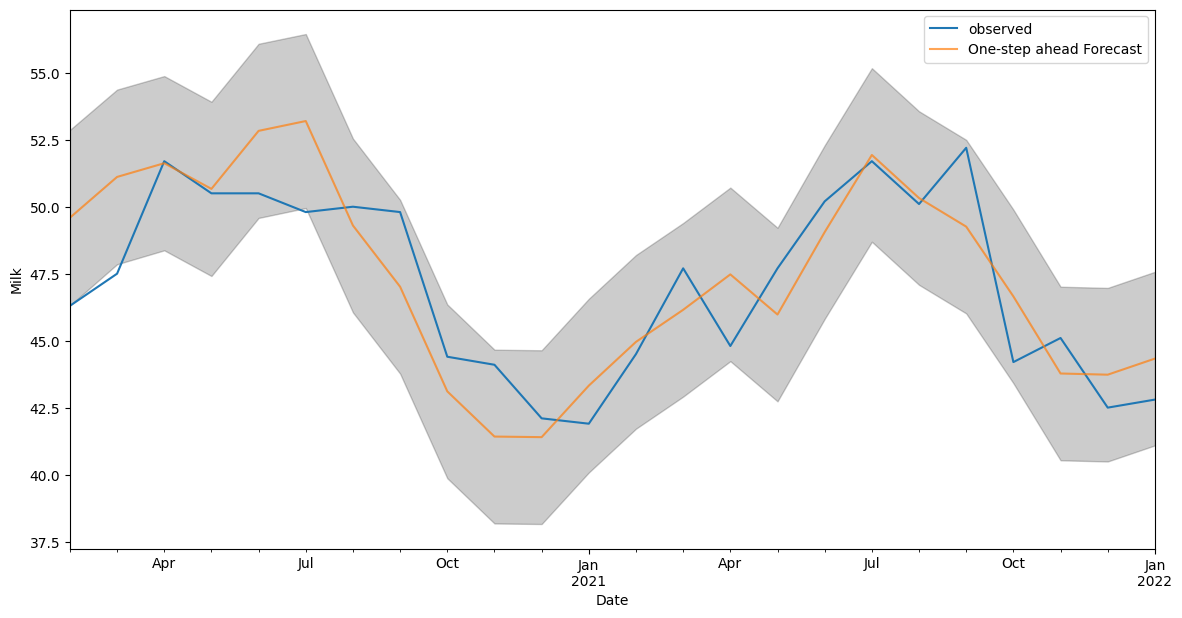

In [74]:
pred_ci = pred.conf_int()
p = pred.predicted_mean

ax = test.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Y')
plt.legend()

plt.show()

## Conclusion

?

